In [18]:
# =========================================
# PART 1: DOWNLOAD & LOAD UCI ELECTRICITY DATASET
# =========================================

!wget -O electricity.zip https://archive.ics.uci.edu/static/public/235/individual+household+electric+power+consumption.zip

!unzip -o electricity.zip

import pandas as pd
import numpy as np

# Load text file
df = pd.read_csv(
    "household_power_consumption.txt",
    sep=';',
    parse_dates={'Datetime': ['Date', 'Time']},
    infer_datetime_format=True,
    na_values='?',
    low_memory=False
)

# Keep only the main power column
df = df[['Datetime', 'Global_active_power']]
df = df.rename(columns={'Global_active_power': 'Load'})
df = df.dropna()

# Convert to float
df['Load'] = df['Load'].astype(float)
df = df.set_index("Datetime")

df.head()


--2025-11-25 13:24:07--  https://archive.ics.uci.edu/static/public/235/individual+household+electric+power+consumption.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘electricity.zip’

electricity.zip         [       <=>          ]  19.68M  12.1MB/s    in 1.6s    

2025-11-25 13:24:09 (12.1 MB/s) - ‘electricity.zip’ saved [20640916]

Archive:  electricity.zip
  inflating: household_power_consumption.txt  


/tmp/ipython-input-771755874.py:13: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(
/tmp/ipython-input-771755874.py:13: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(
/tmp/ipython-input-771755874.py:13: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(


,Load
Datetime,
2006-12-16 17:24:00,4.216
2006-12-16 17:25:00,5.360
2006-12-16 17:26:00,5.374
2006-12-16 17:27:00,5.388
2006-12-16 17:28:00,3.666


In [25]:
# =========================================
# PART 2: CLEANING + HOURLY RESAMPLING
# =========================================

df = df.resample("H").mean()
df = df.resample("H").mean()

# FIX NaN after resampling
df = df.fillna(method="ffill")

# Train-test split (80/20)
split_index = int(len(df) * 0.8)
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]



train_df.shape, test_df.shape


/tmp/ipython-input-2756618967.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample("H").mean()
/tmp/ipython-input-2756618967.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample("H").mean()
/tmp/ipython-input-2756618967.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="ffill")


((27671, 1), (6918, 1))

In [26]:
# =========================================
# PART 3: NORMALIZATION & SEQUENCE CREATION
# =========================================

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)

def create_sequences(data, window):
    X, y = [], []
    for i in range(len(data)-window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

window = 24  # 24-hour lookback

X_train, y_train = create_sequences(train_scaled, window)
X_test, y_test = create_sequences(test_scaled, window)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test  = X_test.reshape((X_test.shape[0],  X_test.shape[1], 1))

X_train.shape, X_test.shape


((27647, 24, 1), (6894, 24, 1))

In [27]:
# =========================================
# PART 4: HYPEROPT + LSTM OBJECTIVE FUNCTION
# =========================================

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf

space = {
    "units": hp.choice("units", [32, 64, 128]),
    "dropout": hp.uniform("dropout", 0.0, 0.4),
    "lr": hp.loguniform("lr", np.log(1e-4), np.log(5e-3)),
    "batch_size": hp.choice("batch_size", [16, 32, 64]),
    "epochs": hp.choice("epochs", [10, 15, 20])
}

def objective(params):

    model = Sequential([
        LSTM(params["units"], return_sequences=False, input_shape=(window, 1)),
        Dropout(params["dropout"]),
        Dense(1)
    ])

    optimizer = Adam(learning_rate=params["lr"])
    model.compile(loss="mse", optimizer=optimizer)

    model.fit(
        X_train, y_train,
        batch_size=params["batch_size"],
        epochs=params["epochs"],
        verbose=0
    )

    preds = model.predict(X_test, verbose=0)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    return {"loss": rmse, "status": STATUS_OK}


In [28]:
# =========================================
# PART 5: RUN HYPEROPT SEARCH
# =========================================

trials = Trials()

best_params = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=20,
    trials=trials
)

best_params


  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



  5%|▌         | 1/20 [02:54<55:08, 174.11s/trial, best loss: 0.07797467510115524]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



 10%|█         | 2/20 [05:27<48:31, 161.75s/trial, best loss: 0.07797467510115524]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



 15%|█▌        | 3/20 [07:55<44:04, 155.54s/trial, best loss: 0.07765396576490702]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



 20%|██        | 4/20 [11:19<46:32, 174.53s/trial, best loss: 0.07765396576490702]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



 25%|██▌       | 5/20 [15:31<50:41, 202.80s/trial, best loss: 0.07765396576490702]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



 30%|███       | 6/20 [27:52<1:29:59, 385.70s/trial, best loss: 0.07746205772917047]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



 35%|███▌      | 7/20 [33:09<1:18:42, 363.24s/trial, best loss: 0.07746205772917047]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



 40%|████      | 8/20 [41:22<1:20:52, 404.34s/trial, best loss: 0.07746205772917047]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



 45%|████▌     | 9/20 [46:41<1:09:17, 377.91s/trial, best loss: 0.07746205772917047]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



 50%|█████     | 10/20 [55:46<1:11:33, 429.34s/trial, best loss: 0.07746205772917047]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



 55%|█████▌    | 11/20 [56:42<47:16, 315.14s/trial, best loss: 0.07746205772917047]  

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



 60%|██████    | 12/20 [1:06:08<52:11, 391.48s/trial, best loss: 0.07746205772917047]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



 65%|██████▌   | 13/20 [1:10:15<40:33, 347.62s/trial, best loss: 0.07746205772917047]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



 70%|███████   | 14/20 [1:13:15<29:42, 297.05s/trial, best loss: 0.0774203704262879] 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



 75%|███████▌  | 15/20 [1:16:35<22:19, 267.88s/trial, best loss: 0.0774203704262879]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



 80%|████████  | 16/20 [1:19:34<16:04, 241.07s/trial, best loss: 0.0774203704262879]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



 85%|████████▌ | 17/20 [1:21:46<10:25, 208.39s/trial, best loss: 0.0774203704262879]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



 90%|█████████ | 18/20 [1:24:23<06:25, 192.75s/trial, best loss: 0.0774203704262879]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



 95%|█████████▌| 19/20 [1:28:51<03:35, 215.42s/trial, best loss: 0.0774203704262879]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



100%|██████████| 20/20 [1:31:52<00:00, 275.62s/trial, best loss: 0.0774203704262879]


{'batch_size': np.int64(1),
 'dropout': np.float64(0.11842757081165663),
 'epochs': np.int64(2),
 'lr': np.float64(0.0015265925982920242),
 'units': np.int64(0)}

In [29]:
# =========================================
# PART 6: FINAL MODEL TRAINING
# =========================================

units_choices = [32, 64, 128]
batch_choices = [16, 32, 64]
epoch_choices = [10, 15, 20]

best = {
    "units": units_choices[best_params["units"]],
    "dropout": best_params["dropout"],
    "lr": best_params["lr"],
    "batch_size": batch_choices[best_params["batch_size"]],
    "epochs": epoch_choices[best_params["epochs"]]
}

print("BEST HYPERPARAMETERS:", best)

model = Sequential([
    LSTM(best["units"], input_shape=(window, 1)),
    Dropout(best["dropout"]),
    Dense(1)
])

model.compile(loss="mse", optimizer=Adam(learning_rate=best["lr"]))

history = model.fit(
    X_train, y_train,
    epochs=best["epochs"],
    batch_size=best["batch_size"],
    verbose=1
)


BEST HYPERPARAMETERS: {'units': 32, 'dropout': np.float64(0.11842757081165663), 'lr': np.float64(0.0015265925982920242), 'batch_size': 32, 'epochs': 20}
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0155
Epoch 2/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0103
Epoch 3/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0094
Epoch 4/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0090
Epoch 5/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0089
Epoch 6/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0088
Epoch 7/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0086
Epoch 8/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0088
Epoch 9/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0090
Epoch 10/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0088
Epoch 11/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0084
Epoch 12/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0085
Epoch 13/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0086
Epoch 14/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0090
Epoch 15/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/ste

216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
RMSE: 0.5035579401854118
MAE: 0.3592037698056313


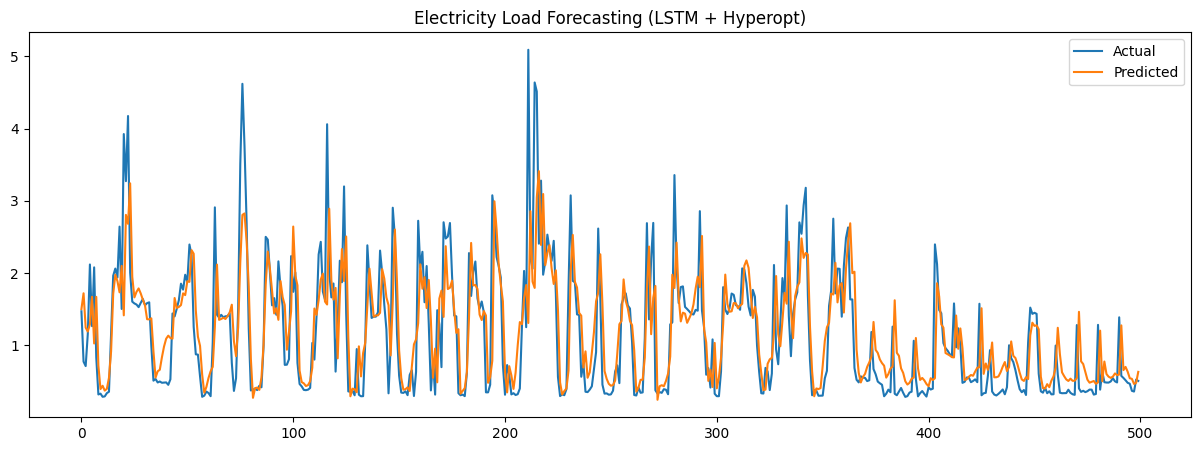

In [30]:
# =========================================
# PART 7: EVALUATION + PLOTTING
# =========================================

preds = model.predict(X_test)
preds_inv = scaler.inverse_transform(preds)
y_test_inv = scaler.inverse_transform(y_test)

rmse = np.sqrt(mean_squared_error(y_test_inv, preds_inv))
mae = mean_absolute_error(y_test_inv, preds_inv)

print("RMSE:", rmse)
print("MAE:", mae)

import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(y_test_inv[:500], label="Actual")
plt.plot(preds_inv[:500], label="Predicted")
plt.legend()
plt.title("Electricity Load Forecasting (LSTM + Hyperopt)")
plt.show()
